# 0. 사용할 패키지 불러오기

In [1]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers.normalization import BatchNormalization
from tensorflow.python.keras.layers.convolutional import Conv2D
from tensorflow.python.keras.layers.convolutional import MaxPooling2D
from tensorflow.python.keras.layers.core import Activation
from tensorflow.python.keras.layers.core import Flatten
from tensorflow.python.keras.layers.core import Dropout
from tensorflow.python.keras.layers.core import Dense
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.python.keras.models import load_model

# 1. 데이터 불러오기

In [2]:
import numpy as np
import glob
import sys
from sklearn.model_selection import train_test_split

x_train = np.empty((0, 120, 320, 1))
y_train = np.empty((0, 4))

training_data = glob.glob('./training_data/*.npz')

for single_npz in training_data:
    with np.load(single_npz) as data:
        x = data['train']
        y = data['train_labels']
    x = np.reshape(x, (-1, 120, 320, 1))
    x_train = np.vstack((x_train, x))
    y_train = np.vstack((y_train, y))


# train test split, 7:3
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.3, random_state = 42)

y_train = y_train[:,:-1]
y_test = y_test[:,:-1]

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(32102, 120, 320, 1) (32102, 3)
(13759, 120, 320, 1) (13759, 3)


# 데이터 확인

In [5]:
#import pandas as pd

#y_data = pd.DataFrame(y_total[:, :])

In [6]:
#y_data.count()

In [7]:
#left = y_data.loc[y_data[:][0] == 1]

In [8]:
#left.count()

In [9]:
#right = y_data.loc[y_data[:][1] == 1]

In [10]:
#right.count()

In [11]:
#forward = y_data.loc[y_data[:][2] == 1]

In [12]:
#forward.count()

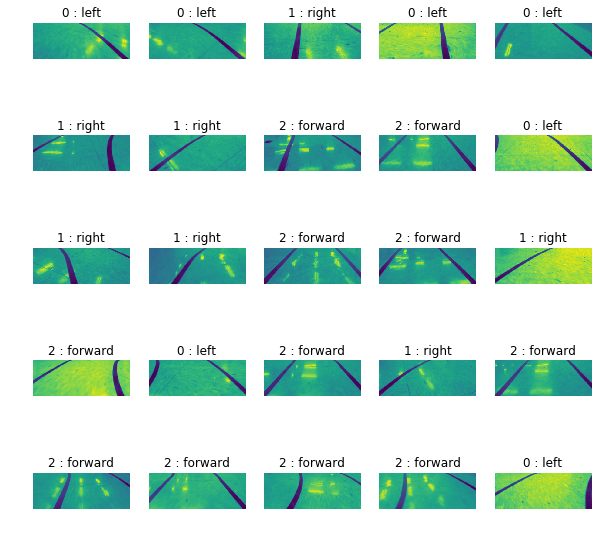

In [7]:
# 데이터 확인

from matplotlib import pyplot as plt
%matplotlib inline

plt_row = 5
plt_col = 5
plt.rcParams["figure.figsize"] = (10,10)

f, axarr = plt.subplots(plt_row, plt_col)

for i in range(plt_row*plt_col):

    sub_plt = axarr[int(i/plt_row), int(i%plt_col)]
    sub_plt.axis('off')
    sub_plt.imshow(x_train[i].reshape(120, 320))
    
    label = np.argmax(y_train[i])
                      
    if label == 0 :
        direction = 'left'
    elif label == 1:
        direction = 'right'
    elif label == 2:
        direction = 'forward'
    elif label == 3:
        direction = 'backward'
                      
    sub_plt_title = str(label) + " : " + direction
    sub_plt.set_title(sub_plt_title)

plt.show()

# 3. 모델 생성

In [46]:
# image size = 160 x 320
def video_model():
    
    # model setting
    H = 120
    W = 320
    CH = 1

    inputShape = (H, W, CH)

    activation = 'relu'
    keep_prob_conv = 0.25
    keep_prob_dense = 0.5

    #init = 'glorot_normal'
    #init = 'he_normal'
    init = 'he_uniform'
    chanDim = -1
    classes = 3
    
    model = Sequential()
    
    # CONV => RELU => POOL
    model.add(Conv2D(3, (3, 3), padding="valid", input_shape=inputShape, kernel_initializer=init))
    model.add(Activation(activation))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(9, (3, 3), padding="valid", kernel_initializer=init))
    model.add(Activation(activation))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(18, (3, 3), padding="valid", kernel_initializer=init))
    model.add(Activation(activation))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(32, (3, 3), padding="valid", kernel_initializer=init))
    model.add(Activation(activation))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Flatten())
    
    model.add(Dense(80, kernel_initializer=init))
    model.add(Activation(activation))
    model.add(Dropout(keep_prob_dense))
    
    model.add(Dense(15, kernel_initializer=init))
    model.add(Activation(activation))
    model.add(Dropout(keep_prob_dense))
    
    # softmax classifier
    model.add(Dense(classes))
    model.add(Activation("softmax"))
    
    return model

In [47]:
model = video_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 118, 318, 3)       30        
_________________________________________________________________
activation_21 (Activation)   (None, 118, 318, 3)       0         
_________________________________________________________________
batch_normalization_18 (Batc (None, 118, 318, 3)       12        
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 59, 159, 3)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 57, 157, 9)        252       
_________________________________________________________________
activation_22 (Activation)   (None, 57, 157, 9)        0         
_________________________________________________________________
batch_normalization_19 (Batc (None, 57, 157, 9)        36        
__________

# 4. 모델 파라미터 셋팅

적은 수의 이미지 데이터가 존재할 경우 데이터를 늘리는 용도로 사용

In [48]:
aug = ImageDataGenerator(rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
    horizontal_flip=True, fill_mode="nearest")

In [49]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

In [50]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.0001)

In [51]:
# initialize the model
# EPOCHS = 50
# INIT_LR = 1e-3
# BS = 32
# split_ratio = 0.2

In [52]:
EPOCHS = 35
INIT_LR = 1e-4
BS = 256
split_ratio = 0.2

print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="categorical_crossentropy", optimizer=opt,
    metrics=["accuracy"])
 

[INFO] compiling model...


# 5. 모델 훈련

In [53]:
hist = model.fit(x_train, y_train, 
                 epochs=EPOCHS, batch_size=BS, 
                 validation_split=split_ratio, 
                 verbose = 1
                 ,callbacks=[reduce_lr]
                )

Train on 25681 samples, validate on 6421 samples
Epoch 1/35
25681/25681 [==============================] - 16s 634us/step - loss: 1.0301 - acc: 0.5710 - val_loss: 0.8412 - val_acc: 0.6616
Epoch 2/35
25681/25681 [==============================] - 15s 570us/step - loss: 0.7744 - acc: 0.6805 - val_loss: 0.5745 - val_acc: 0.7756
Epoch 3/35
25681/25681 [==============================] - 15s 571us/step - loss: 0.6790 - acc: 0.7215 - val_loss: 0.4923 - val_acc: 0.8167
Epoch 4/35
25681/25681 [==============================] - 15s 571us/step - loss: 0.6214 - acc: 0.7478 - val_loss: 0.4636 - val_acc: 0.8282
Epoch 5/35
25681/25681 [==============================] - 15s 573us/step - loss: 0.5891 - acc: 0.7647 - val_loss: 0.4376 - val_acc: 0.8388
Epoch 6/35
25681/25681 [==============================] - 15s 577us/step - loss: 0.5567 - acc: 0.7805 - val_loss: 0.4278 - val_acc: 0.8436
Epoch 7/35
25681/25681 [==============================] - 15s 582us/step - loss: 0.5399 - acc: 0.7911 - val_loss: 0.4

KeyboardInterrupt: 

In [ ]:
plt.subplot(1, 2, 1)
plt.title('model loss')
plt.plot(hist.history['loss'], label="loss")
plt.plot(hist.history['val_loss'], label="val_loss")
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.ylim((0,2))

plt.subplot(1, 2, 2)
plt.title('model accuracy')
plt.plot(hist.history['acc'], label="acc")
plt.plot(hist.history['val_acc'], label="val_acc")
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.ylim((0.4, 1))


plt.show();

# 6. 모델 결과 확인

In [40]:
#l_model = load_model('./model_data/VGG_model.h5')

In [41]:
loss_and_metrics = model.evaluate(x_test, y_test, batch_size=BS)
print('## evaluation loss and_metrics ##')
print(loss_and_metrics)

13759/13759 [==============================] - 4s 296us/step
## evaluation loss and_metrics ##
[0.2976677978798629, 0.8914165276411583]


In [45]:
xhat_idx = np.random.choice(x_test.shape[0], 10)
xhat = x_test[xhat_idx]

yhat_classes = model.predict_classes(xhat)

for i in range(10):
    print('True : ' + str(np.argmax(y_test[xhat_idx[i]])) + ', Predict : ' + str(yhat_classes[i]))

True : 2, Predict : 2
True : 1, Predict : 1
True : 2, Predict : 2
True : 2, Predict : 2
True : 0, Predict : 0
True : 0, Predict : 0
True : 2, Predict : 2
True : 2, Predict : 2
True : 1, Predict : 1
True : 0, Predict : 2


# 7. 최종 모델 훈련

In [3]:
x_total = np.vstack((x_train, x_test))
y_total = np.vstack((y_train, y_test))

print(x_total.shape)
print(y_total.shape)

(45861, 120, 320, 1)
(45861, 3)


In [10]:
early_stopping = EarlyStopping(monitor='loss', patience=10)

In [11]:
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2,
                              patience=5, min_lr=0.0001)

In [12]:
EPOCHS = 40
INIT_LR = 1e-4
BS = 256
split_ratio = 0.2

print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="categorical_crossentropy", optimizer=opt,
    metrics=["accuracy"])

[INFO] compiling model...


In [13]:
hist = model.fit(x_total, y_total, 
                 epochs=EPOCHS, batch_size=BS, 
                 #validation_split=split_ratio, 
                 verbose = 1
                 ,callbacks=[reduce_lr]
                )

Epoch 1/50
45861/45861 [==============================] - 33s 721us/step - loss: 0.8918 - acc: 0.6223
Epoch 2/50
45861/45861 [==============================] - 22s 489us/step - loss: 0.6465 - acc: 0.7359
Epoch 3/50
45861/45861 [==============================] - 23s 496us/step - loss: 0.5758 - acc: 0.7756
Epoch 4/50
45861/45861 [==============================] - 23s 500us/step - loss: 0.5169 - acc: 0.8026
Epoch 5/50
45861/45861 [==============================] - 23s 493us/step - loss: 0.4811 - acc: 0.8197
Epoch 6/50
45861/45861 [==============================] - 23s 494us/step - loss: 0.4521 - acc: 0.8324
Epoch 7/50
45861/45861 [==============================] - 23s 495us/step - loss: 0.4244 - acc: 0.8471
Epoch 8/50
45861/45861 [==============================] - 23s 494us/step - loss: 0.4064 - acc: 0.8530
Epoch 9/50
45861/45861 [==============================] - 23s 497us/step - loss: 0.3855 - acc: 0.8613
Epoch 10/50
45861/45861 [==============================] - 23s 498us/step - loss: 

In [14]:
loss_and_metrics = model.evaluate(x_test, y_test, batch_size=BS)
print('## evaluation loss and_metrics ##')
print(loss_and_metrics)

13759/13759 [==============================] - 4s 312us/step
## evaluation loss and_metrics ##
[0.10302396099904793, 0.9585725703647693]


In [20]:
xhat_idx = np.random.choice(x_test.shape[0], 10)
xhat = x_test[xhat_idx]

yhat_classes = model.predict_classes(xhat)

for i in range(10):
    print('True : ' + str(np.argmax(y_test[xhat_idx[i]])) + ', Predict : ' + str(yhat_classes[i]))

True : 1, Predict : 1
True : 2, Predict : 2
True : 1, Predict : 1
True : 2, Predict : 2
True : 2, Predict : 2
True : 2, Predict : 2
True : 1, Predict : 1
True : 0, Predict : 2
True : 0, Predict : 2
True : 0, Predict : 0


# 8. 모델 저장

In [15]:
model.save('./model_data/video_model_2.h5')